# DSE 2018 EDA Notebook

Modeling and Error Analysis

In [1]:
# import cell and define data paths
import copy
import pandas as pd
import missingno
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import math
import scipy
from matplotlib import rc
from scipy.stats import probplot
import seaborn as sns
from scripts import zillow_data_loader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import QuantileTransformer
from scripts.zillow_data_loader import load_test_data
from scripts.modeling_scripts import fix_nan_train_test
from scripts.modeling_scripts import fetch_experiment_datasets
from scripts.modeling_scripts import lgb_fit_predict_validation
from scripts.modeling_scripts import stack_model_pred
from scripts.modeling_scripts import init_lgb_model
from scripts.modeling_scripts import makedist_qq_plot
from scripts.modeling_scripts import make_submission
from catboost import CatBoostRegressor
from catboost import Pool
import lightgbm as lgb
import warnings

warnings.filterwarnings('ignore')

import shap
%matplotlib inline
#previously identified useful variables
data_dir = "~/kaggle/zillow/"
fig_write_dir = "tex_src/figures/eps/"


train_set, holdout_set = fetch_experiment_datasets()

Using TensorFlow backend.


Shape Of Loaded Merged Zillow Data:  (167888, 63)
train_set shape (151928, 63)
holdout_set shape (15960, 63)


training  1 of 5
training  2 of 5
training  3 of 5
training  4 of 5
training  5 of 5
abs validation residuals: 0.06990372513317289
0.07149693285434311 res


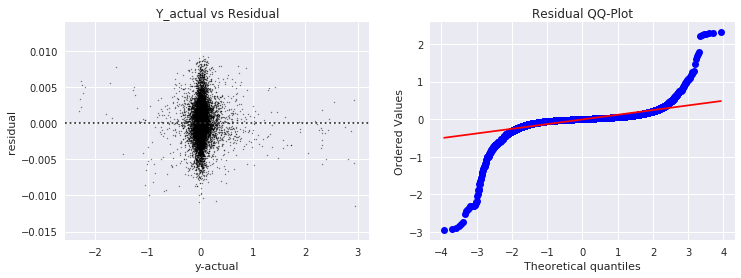

abs holdout residuals: 0.07149693285434311


In [2]:
model = init_lgb_model()

numerical_vars =['bathroomcnt', 'bedroomcnt', 'calculatedbathnbr',
                 'calculatedfinishedsquarefeet', 'finishedsquarefeet12',
                 'fullbathcnt', 'landtaxvaluedollarcnt', 'latitude',
                 'longitude', 'lotsizesquarefeet', 'roomcnt',
                 'structuretaxvaluedollarcnt', 'taxamount', 'taxvaluedollarcnt',
                 'yearbuilt']
categorical_vars = ['censustractandblock', 'fips', 'propertycountylandusecode',
                 'propertylandusetypeid', 'rawcensustractandblock',
                 'regionidcity', 'regionidzip']




cat_feats = ['transaction_month','transaction_year']+categorical_vars
train_features = numerical_vars+cat_feats


k_folds = 5
fixed_train, fixed_holdout = fix_nan_train_test(train_set,holdout_set,
                                                numerical_vars,None)

#dist = scipy.stats.t
full_feats_modeling_output = lgb_fit_predict_validation(k_folds,fixed_train,
                                                 train_features,cat_feats,
                                                 model)
stack_model_pred(full_feats_modeling_output,fixed_holdout,train_features,'logerror')

In [3]:
#test_df = load_test_data()
#make_submission(full_feats_modeling_output['models'],train_features,test_df,'full_feat_sub.csv')

In [4]:
full_fe_imp = pd.DataFrame()
full_fe_imp['feat_names']= train_features
fi_list = []
#print(modeling_output['models'][0].feature_importances_(importance_type='split'))
for ith,lgb_model in enumerate(full_feats_modeling_output['models']):
    fi_list.append(lgb_model.feature_importances_)
fi_list = np.average(np.array(fi_list),axis=0)
total=np.sum(fi_list)
print('total',total)
fi_list_perc = np.divide(fi_list,total)
fi_list_perc = fi_list_perc.reshape(-1,1)
full_fe_imp['split_imp']=fi_list_perc


total 15550.0


training  1 of 5
training  2 of 5
training  3 of 5
training  4 of 5
training  5 of 5
abs validation residuals: 0.06997057370951927
0.07158004485024791 res


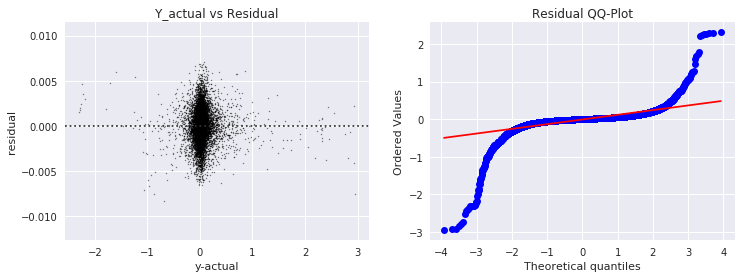

abs holdout residuals: 0.07158004485024791


In [5]:
model = init_lgb_model()

numerical_vars = ['taxamount', 'bedroomcnt','lotsizesquarefeet',
                  'latitude', 'longitude',  'roomcnt','yearbuilt']

categorical_vars = ['fips','propertycountylandusecode',
                 'propertylandusetypeid']




cat_feats = ['transaction_month','transaction_year']+categorical_vars
train_features = numerical_vars+cat_feats


k_folds = 5
fixed_train, fixed_holdout = fix_nan_train_test(train_set,holdout_set,
                                                numerical_vars,None)

#dist = scipy.stats.t
best_feats_modeling_output = lgb_fit_predict_validation(k_folds,fixed_train,
                                                 train_features,cat_feats,
                                                 model)



stack_model_pred(best_feats_modeling_output,fixed_holdout,train_features,'logerror')

In [6]:
best_fe_imp = pd.DataFrame()
best_fe_imp['feat_names']= train_features
fi_list = []
#print(modeling_output['models'][0].feature_importances_(importance_type='split'))
for ith,lgb_model in enumerate(best_feats_modeling_output['models']):
    fi_list.append(lgb_model.feature_importances_)
fi_list = np.average(np.array(fi_list),axis=0)
total=np.sum(fi_list)
fi_list_perc = np.divide(fi_list,total)
fi_list_perc = fi_list_perc.reshape(-1,1)
print(full_fe_imp.shape)
best_fe_imp['split_imp']=fi_list_perc
#make_submission(best_feats_modeling_output['models'],
#                train_features,test_df,'best_feat_sub.csv')

(24, 2)


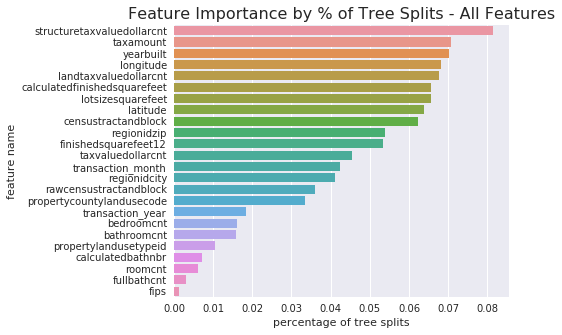

In [9]:
full_fe_imp.sort_values(by='split_imp' ,ascending=False,inplace=True)


f, (ax_box) = plt.subplots(figsize=(6,5))
sns_plot = sns.barplot(y="feat_names", x="split_imp", data=full_fe_imp, ax=ax_box)
ax_box.set(ylabel='feature name',xlabel='proportion of tree splits')
plt.title('Feature Importance by % of Tree Splits - All Features', fontsize=16)
plt.show()
out = sns_plot.get_figure()


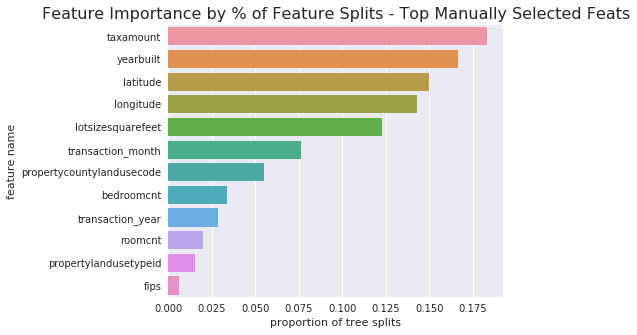

In [10]:
best_fe_imp.sort_values(by='split_imp' ,ascending=False,inplace=True)


f, (ax_box) = plt.subplots(figsize=(6,5))
sns_plot = sns.barplot(y="feat_names", x="split_imp", data=best_fe_imp,ax=ax_box)
plt.title('Feature Importance by % of Feature Splits - Top Manually Selected Feats', fontsize=16)
ax_box.set(ylabel='feature name',xlabel='proportion of tree splits')

plt.show()
out = sns_plot.get_figure()


In [ ]:
best_fe_imp = pd.DataFrame()
best_fe_imp['feat_names']= train_features
fi_list = []
#print(modeling_output['models'][0].feature_importances_(importance_type='split'))
for ith,lgb_model in enumerate(best_feats_modeling_output['models']):
    fi_list.append(lgb_model.feature_importances_)
fi_list = np.average(np.array(fi_list),axis=0)
total=np.sum(fi_list)
fi_list_perc = np.divide(fi_list,total)
fi_list_perc = fi_list_perc.reshape(-1,1)
print(full_fe_imp.shape)
best_fe_imp['split_imp']=fi_list_perc
#make_submission(best_feats_modeling_output['models'],
#                train_features,test_df,'best_feat_sub.csv')